# Projet statistiques / dimanche 02 avril avant 23h59 sinon pénalité
## Objectif : retrouver la langue maternelle (origine) de l'auteur d'un texte écrit en anglais
## Plan :
- svm vs logistic regression
- fonction d'évaluation des modèles
    - plusieurs métriques : accuracy, précision, recall, f1.
        - utiliser la 'macro' f-mesure pour voir l'evaluation de chaque categorie.
    - matrice de confusion sur toutes les origines.
        - essayer de regrouper les origines difficiles à séparer (former des sortes de petites matrices)
- bag of words vs tf-idf
- remove stop words or not
    - lister tous les mots du vocab avec les fréquences, pour trier une liste de mots outils (on se décide nous même de la liste), lemmatization nécessaire pour cette étape.
- lemmatization or not
    - logiquement dans notre cas d'usage, ne pas le faire car on se concentre sur la recherche de singularités, alors que la lemmatization recherche la généralité.
- stemming or not
    - pareil
- fonction qui liste tous les caractères et compte les fréquences, pour voir s'il y a des caractères bizarres (zero-width .. ?)
    - normalement pas de soucis car le prof a travaillé déjà dessus.
- séparation des mots
    - I’m, can’t : ne pas séparer pour notre cas d’usage.
- A explorer (on peut ajouter des choses dans le vecteur) :
    - on peut compter la ponctuation
        - visualisation possible avec des camemberts de couleurs
    - compter le nombre de caractères spéciaux (nombre d’apostrophes...)
        - aussi visualisation possible avec des camemberts de couleurs
    - longueur moyenne des phrases
    - nombre de mots différents dans le texte
    - fréquence de mot le plus utilisé
    - prendre chaque mot et voir s’il existe dans un dictionnaire, s’il n’est pas présent donc faute d'orthographe… puis peut être le nombre de fautes, ou faire le lien…
- avec un SVM on peut regarder les poids en sortie
- discrétisation ?
    - on peut dessiner une gaussienne avec les longueurs moyennes des phrases. si on a pas une gaussienne, regarder chaque catégorie
    
## Bilan :
dernière séance où on fera la liste de tout ce qu'on a testé pour voir pourquoi ça a marché ou cela n'a pas marché.

## Rendu
envoyer avec l'adresse paris saclay !
mettre dans le corps du message, dans le rapport, dans le code : les noms du binome.

### un seul format de rapport : PDF.
simple, propre et lisible.
pas la peine de reproduire le cours, on virect au but.
contenu : journal d'expérimentation:
1. idée de base qu'on veut tester.
2. hipothèse
3. implémentation (codée, existente, compliquée...)
4. résultat
5. analyse : le fait de faire ça nous a fait gagner 3 points de F-mesure, et en analysant .. on remarque que enlever/ajouter/modifier... a un effet sur qqchose..
avoir un aspect critique : pourquoi l'implémentation de départ ne marche pas.. observations..

### code (notebook..) : archive ZIP ou TGZ.
code python : notebook ou fichier
si besoin de lib qui ne sont pas dans la lib de base: mettre un readme pour préciser, pareil pour les versions.
si compliqué à lancer : expliquer dans le readme.
ne pas joindre les data ni les modèles.

base line du prof : 0.63 de f-mesure.
test sur 1100 textes (100 de chaque langue) (à voir  si on utilise cette info)
on fait tourner dessus on obtient les prédictions finales.

joindre un fichier .txt et sur chaque ligne y'a la prédiction (attention à l'ordre des lignes)

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Lecture du dataframe
def load_data(path=r'./train.txt'):
    df = pd.read_csv(path, header=None, sep=':::')
    df['text']=df[0].str.extract(r'^\([A-Z]{3}\) (.*)$')
    df['category']=df[0].str.extract(r'^\(([A-Z]{3})\)')
    df = df.drop([0], axis=1)
    return df

df = load_data()
df

/tmp/ipykernel_6474/588828588.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, header=None, sep=':::')


,text,category
0,IThe importance and popularity of travelling i...,GER
1,"It is an important decision , how to plan your...",TUR
2,Some people believe that young people can enjo...,CHI
3,Travelling is usually considered as good recre...,TEL
4,i agree that . Life is a person live period of...,ARA
...,...,...
9895,"Nowadays , more and more people go abroad , no...",CHI
9896,In accomplishing something that is risky comes...,KOR
9897,"At the beginning of the 21st century , the inc...",SPA
9898,The number of cars in use across the world has...,HIN


In [3]:
# exemple de text
df['text'][1]

'It is an important decision , how to plan your syllabus . Some students prefer to take a lot of courses and expand their knowledge , whereas some other prefer to specialize in one specific subject . In this essay I will dwell on the advantages of specializing in one subject and argue in its favor . There are at least three reasons why choosing one subject is better than trying to keep balance between many subjects . The first and most important reason for me is that this way people concentrate on one thing and do not feel anxiety about time-management and deadlines . In contrast , student who take three or four subjects are very busy and stressed , because they have to prepare for many exams and see different lecturers , which is confusing and the results are not as good as those of the ones from the one subject plan . In addition , when one specializes in one subject then this person has more chances to be well-informed about it and do his best , being sure he recieves the best knowl

### Remarque :
Tous les mots sont bien séparés avec des espaces, même la ponctuation.

In [4]:
df['category'].value_counts()

GER    900
TUR    900
CHI    900
TEL    900
ARA    900
SPA    900
HIN    900
JPN    900
KOR    900
FRE    900
ITA    900
Name: category, dtype: int64

### Note :
Nous avons 11 langues maternelles (origines) avec 900 observations (texts) pour chaque origine.

## Visualisations

In [5]:
# visualisations

### On teste quelques modèles sur nos données brutes pour avoir une idée sur lequel on pourrait choisir, en utilisant les deux méthodes Bag Of Words et Tf-idf

In [6]:
# split data
X = df['text'].values.tolist()
y = df['category'].values.tolist()

# Construire les vecteurs BoW & Tfidf ( CountVectorizer & TfidfVectorizer )
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# CountVectorizer
cv = CountVectorizer(stop_words='english')
cv_X = cv.fit_transform(X)

# tf-idf
tf = TfidfVectorizer(stop_words='english') #ici on peut ajouter min_df, max_df. voir la doc de TfidfVectorizer !!
tf_X = tf.fit_transform(X)

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("len X_train =", len(X_train), "len X_test =", len(X_test))

# CV transform X to vectors
cv_X_train = cv.transform(X_train)
cv_X_test = cv.transform(X_test)

# Label encoder for y
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.category.unique())

train_category = le.fit_transform(y_train)
test_category = le.fit_transform(y_test)

# to inverse transform we use :
#le.inverse_transform([0, 1, 2, 3, 4])
d = zip([i for i in range(len(df.category.unique()))], le.inverse_transform([i for i in range(len(df.category.unique()))]))
class_labels_dict = {}
for k,v in d:
    class_labels_dict[k] = v
print("Labelled classes : ", class_labels_dict)

# class_labels_dict[index] = LANGUAGE

len X_train = 7920 len X_test = 1980
Labelled classes :  {0: 'ARA', 1: 'CHI', 2: 'FRE', 3: 'GER', 4: 'HIN', 5: 'ITA', 6: 'JPN', 7: 'KOR', 8: 'SPA', 9: 'TEL', 10: 'TUR'}


In [7]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(cv_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(cv_X_test)
print(len(logisticRegr_predict))

1980


/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
print(logisticRegr_predict)
print(test_category)

[10  5  2 ...  5  7  5]
[10  5  8 ...  5  7  8]


In [9]:
print("Score logistic regression with bag of words whithout cleaning text :", logisticRegr.score(cv_X_test, test_category))

Score logistic regression with bag of words whithout cleaning text : 0.6161616161616161


In [10]:
# SVM linear
from sklearn.svm import SVC
sv = SVC(kernel='linear', C=1E10)
bow_sv = sv.fit(cv_X_train, train_category)

In [11]:
bow_sv_predict = bow_sv.predict(cv_X_test)
print(len(bow_sv_predict))
print("Score linear SVM with bag of words whithout cleaning text :", sv.score(cv_X_test, test_category))

1980
Score linear SVM with bag of words whithout cleaning text : 0.555050505050505


In [12]:
# SVM RBF
from sklearn.svm import SVC
svm_rbf = SVC(kernel='rbf', C=1E10)
svm_rbf.fit(cv_X_train, train_category)

svm_rbf_predict = svm_rbf.predict(cv_X_test)
print(len(svm_rbf_predict))
print("Score RBF SVM with bag of words whithout cleaning text :", svm_rbf.score(cv_X_test, test_category))

1980
Score RBF SVM with bag of words whithout cleaning text : 0.5722222222222222


### Remarque :
En testant ces 3 modèles sans nettoyage des textes et avec le bag of words :
La régression logistique est celle qui donne le meilleure score, comparé au SVMs (même si le SVM avec kernel RBF est mieux que le SVM linéaire mais il reste en dessous).

In [102]:
y_test = test_category
y_pred = logisticRegr.predict(cv_X_test)

"\n# Add labels to the plot\nclass_names = [i for i in range(len(df.category.unique()))]\ntick_marks = np.arange(len(class_names))\ntick_marks2 = tick_marks + 0.5\nplt.xticks(tick_marks, class_names, rotation=25)\nplt.yticks(tick_marks2, class_names, rotation=0)\nplt.xlabel('Predicted label')\nplt.ylabel('True label')\nplt.title('Confusion Matrix')\nplt.show()\n"

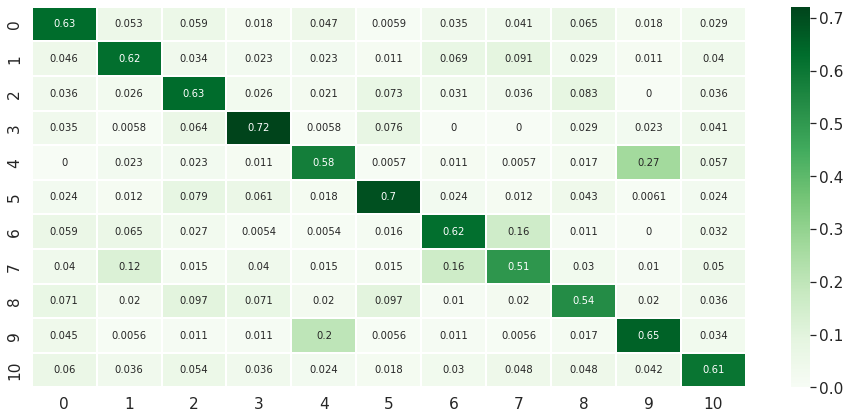

In [103]:
# Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# If you're working in Jupyter Notebook, include the following so that plots will display:
%matplotlib inline


# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
"""
# Add labels to the plot
class_names = [i for i in range(len(df.category.unique()))]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
"""

## Evaluation functions

In [189]:
def print_metrics(y_test, y_pred):
    # micro : Calculate metrics globally by counting the total true positives, false negatives and false positives.
    # macro : faire le calcul étiquette par étiquette, puis faire la moyenne
    labels_list=['ARA','CHI','FRE','GER','HIN','ITA','JPN','KOR','SPA','TEL','TUR']
    average_param = "macro"
    print("\nAccuracy ", accuracy_score(y_test, y_pred))

    print("\n- Precision -", average_param)
    tmp = "\n"+str(list(zip(labels_list, precision_score(y_test, y_pred, average=None, zero_division=1))))
    print("precision by language :", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nprecision score ", precision_score(y_test, y_pred, average=average_param, zero_division=1))

    print("\n- Recall -", average_param)
    tmp = "\n"+str(list(zip(labels_list, recall_score(y_test, y_pred, average=None, zero_division=1))))
    print("recall by language ", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nrecall score ",   recall_score(y_test, y_pred, average=average_param, zero_division=1))
    tmp = "\n"+str(list(zip(labels_list, f1_score(y_test, y_pred, average=None, zero_division=1))))
    
    print("\n- F1 -", average_param)
    print("f1 by language ", tmp.replace("),",")\n").replace("[",'').replace("]",''))
    print("\nf1 score ", f1_score(y_test, y_pred, average=average_param, zero_division=1))
    
#print_metrics(y_test, y_pred)

In [190]:
def draw_confusion_matrix(y_test, y_pred, langs_label=['ARA',\
 'CHI',
 'FRE',
 'GER',
 'HIN',
 'ITA',
 'JPN',
 'KOR',
 'SPA',
 'TEL',
 'TUR'], 
                          class_labels_dict=class_labels_dict):
    import plotly.express as px
    lang2num = {v: k for k, v in class_labels_dict.items()}
    lang_list =  [ lang2num[k] for k in langs_label] 
    data = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=lang_list)
    fig = px.imshow(data,
                    labels=dict(x="Languages y_test", y="Languages y_pred", color="confusion"),
                    x=langs_label,
                    y=langs_label,
                    text_auto=True,
                    aspect="auto")
    fig.update_xaxes(side="top")
    fig.show()


In [191]:
def evaluation(y_test, y_pred, labels_list=['ARA',\
 'CHI',
 'FRE',
 'GER',
 'HIN',
 'ITA',
 'JPN',
 'KOR',
 'SPA',
 'TEL',
 'TUR'],
               class_labels_dict:dict=class_labels_dict, 
               exclude:list=[""]):
    print("\n-- EVALUATION --\n")
    draw_confusion_matrix(y_test, y_pred, langs_label=labels_list, class_labels_dict=class_labels_dict)

    print_metrics(y_test, y_pred)
   

In [192]:
evaluation(y_test, y_pred)


-- EVALUATION --




Accuracy  0.6161616161616161

- Precision - macro
precision by language : 
('ARA', 0.5846994535519126)
 ('CHI', 0.615819209039548)
 ('FRE', 0.5980392156862745)
 ('GER', 0.6927374301675978)
 ('HIN', 0.6)
 ('ITA', 0.6551724137931034)
 ('JPN', 0.6203208556149733)
 ('KOR', 0.576271186440678)
 ('SPA', 0.6140350877192983)
 ('TEL', 0.6256684491978609)
 ('TUR', 0.5964912280701754)

precision score  0.6162958662983111

- Recall - macro
recall by language  
('ARA', 0.6294117647058823)
 ('CHI', 0.6228571428571429)
 ('FRE', 0.6321243523316062)
 ('GER', 0.7209302325581395)
 ('HIN', 0.5795454545454546)
 ('ITA', 0.6951219512195121)
 ('JPN', 0.6236559139784946)
 ('KOR', 0.5074626865671642)
 ('SPA', 0.5357142857142857)
 ('TEL', 0.6536312849162011)
 ('TUR', 0.6071428571428571)

recall score  0.6188725387760672

- F1 - macro
f1 by language  
('ARA', 0.6062322946175637)
 ('CHI', 0.6193181818181819)
 ('FRE', 0.614609571788413)
 ('GER', 0.7065527065527065)
 ('HIN', 0.5895953757225433)
 ('ITA', 0.6745562130

## TF-IDF vs Bag of Words

In [193]:
# tf-idf transform
tf_X_train = tf.transform(X_train)
tf_X_test = tf.transform(X_test)

In [194]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(tf_X_train, train_category)
logisticRegr_predict = logisticRegr.predict(tf_X_test)
print(len(logisticRegr_predict))

1980


/home/clinton/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [195]:
print("Score logistic regression with TF-IDF whithout cleaning text :", logisticRegr.score(tf_X_test, test_category))

Score logistic regression with TF-IDF whithout cleaning text : 0.6464646464646465


In [197]:
evaluation(test_category, logisticRegr_predict)


-- EVALUATION --




Accuracy  0.6464646464646465

- Precision - macro
precision by language : 
('ARA', 0.6075949367088608)
 ('CHI', 0.6363636363636364)
 ('FRE', 0.7150837988826816)
 ('GER', 0.7105263157894737)
 ('HIN', 0.5671641791044776)
 ('ITA', 0.6455026455026455)
 ('JPN', 0.6910112359550562)
 ('KOR', 0.6540880503144654)
 ('SPA', 0.675)
 ('TEL', 0.6559139784946236)
 ('TUR', 0.5647668393782384)

precision score  0.6475468742267417

- Recall - macro
recall by language  
('ARA', 0.5647058823529412)
 ('CHI', 0.68)
 ('FRE', 0.6632124352331606)
 ('GER', 0.7848837209302325)
 ('HIN', 0.6477272727272727)
 ('ITA', 0.7439024390243902)
 ('JPN', 0.6612903225806451)
 ('KOR', 0.5174129353233831)
 ('SPA', 0.5510204081632653)
 ('TEL', 0.6815642458100558)
 ('TUR', 0.6488095238095238)

recall score  0.6495026532686246

- F1 - macro
f1 by language  
('ARA', 0.5853658536585367)
 ('CHI', 0.6574585635359116)
 ('FRE', 0.6881720430107526)
 ('GER', 0.7458563535911603)
 ('HIN', 0.6047745358090185)
 ('ITA', 0.6912181303116147)
 

## Cleaning text

In [25]:
# cleaning test
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean the input text 
    """
    cleaned_text = text.lower()
    cleaned_text = re.sub('[^a-zA-Z0-9$\s]', '', cleaned_text)
    cleaned_text = cleaned_text.split()
    cleaned_text = [word for word in cleaned_text if word not in stopwords and len(word) > 1]
    
    return " ".join(cleaned_text)

df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x))
df

,text,category,cleaned_text
0,IThe importance and popularity of travelling i...,GER,ithe importance popularity travelling still ra...
1,"It is an important decision , how to plan your...",TUR,important decision plan syllabus students pref...
2,Some people believe that young people can enjo...,CHI,people believe young people enjoy life older p...
3,Travelling is usually considered as good recre...,TEL,travelling usually considered good recreation ...
4,i agree that . Life is a person live period of...,ARA,agree life person live period time people beli...
...,...,...,...
9895,"Nowadays , more and more people go abroad , no...",CHI,nowadays people go abroad matter children old ...
9896,In accomplishing something that is risky comes...,KOR,accomplishing something risky comes reward suc...
9897,"At the beginning of the 21st century , the inc...",SPA,beginning 21st century increasing number cars ...
9898,The number of cars in use across the world has...,HIN,number cars use across world growing steadily ...
